# Hub'Eau time series univariate forecasting

Setup our working environment first in order to be able to display some data and make training/prediction:

In [2]:
import math
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

Then read data from a station to be used for training the model and display it:

array([<AxesSubplot:xlabel='date_obs'>], dtype=object)

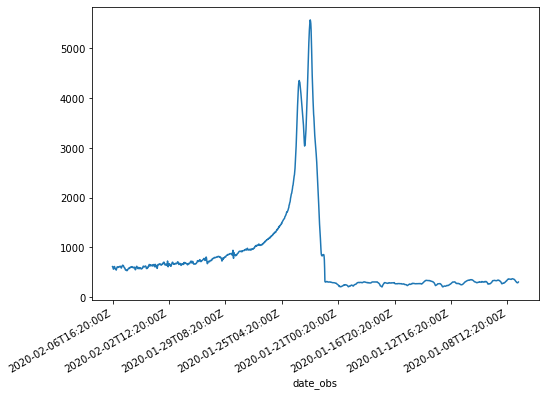

In [4]:
# Data for training
raw = pd.read_csv("data/raw/train_data/hubeau_site_Y1422030_30d_30m_L'Aude.csv", delimiter=';')
data = raw['resultat_obs']
data.index = raw['date_obs']
data.head()
data.plot(subplots=True)

Read data from a station at a different time period to be used for validating the model and display it:

array([<AxesSubplot:xlabel='date_obs'>], dtype=object)

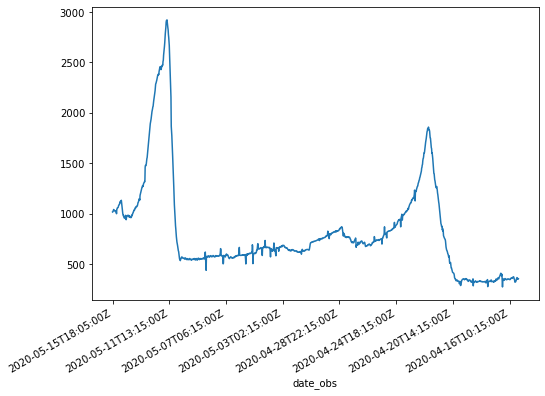

In [5]:
# Data for validation
validation_raw = pd.read_csv("data/raw/validation_data/hubeau_site_Y1422030_2020-04-15_30d_30m_L'Aude.csv", delimiter=';')
validation_data = validation_raw['resultat_obs']
validation_data.index = validation_raw['date_obs']
validation_data.head()
validation_data.plot(subplots=True)

We will work with two setups:
* a single-step setup where the model learns to predict a single point in the future based on some history provided
* a multi-step setup where given a past history the model needs to learn to predict a range of future values 

Let's say you want to predict the water level 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 240 (5x48) observations to train the model if your time step is 30 minutes (2 observations per hour). Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict, ie the label(s) that needs to be predicted: a single value for single-step setup and a set of values for multi-step setup.


In [6]:
def data_windows(dataset, history_size, target_size, single_step=False):
  data = []
  labels = []
  # We cannot extract window if less than history_size past data available
  start_index = history_size
  # We cannot extract label(s) if less than target_size data ahead
  end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    # Range is past window size from current index
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    # Push single or multiple label(s)
    if single_step:
      labels.append(dataset[i+target_size])
    else:
      labels.append(dataset[i:i+target_size])
    
  return np.array(data), np.array(labels)

Now we define some constants for model fit and some helper functions to display model performances:

In [7]:
# Training paramaters
epochs = 10
steps_per_epoch = 100
validation_steps = 50

# Used to normalize/denormalize data
def normalize(data, mean, std):
  return (data - mean) / std

def denormalize(data, mean, std):
  return data * std + mean

# Used to plot training/validation loss
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))

  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

# Used to plot input window/label and prediction in single-step setup
def show_single_plot(history, true_future, offset, prediction, title, mean, std):
  plt.figure(figsize=(12, 6))
  # Past data are before 0
  num_in = list(range(-len(history), 0))
  # Then prediction after 0
  num_out = np.array([offset])

  plt.title(title)
  plt.plot(num_in, np.array(denormalize(history, mean, std)), label='History')
  plt.plot(num_out, np.array(denormalize(true_future, mean, std)), 'bo',
           label='True Future')
  if prediction:
    plt.plot(num_out, np.array(denormalize(prediction, mean, std)), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

# Used to plot input window/label and prediction in multiple-step setup
def show_multiple_plot(history, true_future, prediction, title, mean, std):
  plt.figure(figsize=(12, 6))
  # Past data are before 0
  num_in = list(range(-len(history), 0))
  # Then prediction after 0
  num_out = np.arange(len(true_future))

  plt.title(title)
  plt.plot(num_in, np.array(denormalize(history, mean, std)), label='History')
  plt.plot(num_out, np.array(denormalize(true_future, mean, std)), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(num_out, np.array(denormalize(prediction, mean, std)), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
    
# Used to plot raw data vs model data (i.e. prediction)
# Also compute different errors
def show_prediction(data, prediction, title):
  if data:
    time_steps = list(range(0, len(data)))
  else:
    time_steps = list(range(0, len(prediction)))
  plt.title(title)
  if data:
    plt.plot(time_steps, np.array(data), '-', label='Data')
  if prediction:
    plt.plot(time_steps, np.array(prediction), '-', label='Model Prediction')
  plt.legend()
  plt.xlabel('Time Step')
  plt.show()
  mae = np.absolute(np.subtract(data,prediction)).mean()
  print ('Mean Absolute Error {:4.2f}'.format(mae))
  mae = np.max(np.subtract(data,prediction))
  print ('Max Absolute Error {:4.2f}'.format(mae))
  mape = np.absolute(np.divide(np.subtract(data,prediction), data)).mean()
  print ('Mean Absolute Percentage Error {:4.2f}%'.format(100*mape))
  mape = np.max(np.absolute(np.divide(np.subtract(data,prediction), data)))
  print ('Max Absolute Percentage Error {:4.2f}%'.format(100*mape))
  mse = np.square(np.subtract(data,prediction)).mean()
  print ('Mean Squared Error {:4.2f}'.format(mse))
  print ('Root Mean Squared Error {:4.2f}'.format(math.sqrt(mse)))

We can keep 75% of the training dataset to train and the remaining 25% would be the validation data. However, we prefer to use two really different datasets in order to ensure our model is generalizing correctly to unseen data. We split our validation dataset into two parts, 50% for training validation and 50% we will use to test the model against unseen data.

First we need to standardize the data (i.e. transform data to have a mean of zero and a standard deviation of 1):

In [8]:
print('Training dataset length is {}'.format(data.size))
mean = data.values.mean()
std = data.values.std()
print ('Training Mean value {} - Std value {}'.format(mean, std))
ndata = normalize(data.values, mean, std)

print('Validation dataset length is {}'.format(validation_data.size))
vmean = validation_data.values.mean()
vstd = validation_data.values.std()
print ('Validation Mean value {} - Std value {}'.format(vmean, vstd))
nvdata = normalize(validation_data.values, mean, std)

Training dataset length is 1440
Training Mean value 764.8993055555555 - Std value 867.8262052389971
Validation dataset length is 1432
Validation Mean value 822.6382681564246 - Std value 491.7656981039218


We first start with the single step setup: the model learns to predict a single point in the future based on some history provided. Let's now create the data for the model, it will be given the last N recorded observations (eg 24 observations - 12H if your time step is 30 minutes), and needs to learn to predict the level in Y hours (eg 8 observations - 4H ahead if your time step is 30 minutes).

Timestep 30m - History 12h - Looking 240m ahead
Sample window [[-0.17272964]
 [-0.18540499]
 [-0.21075568]
 [-0.23149716]
 [-0.22919256]
 [-0.20499416]
 [-0.17157733]
 [-0.17157733]
 [-0.19692803]
 [-0.20729877]
 [-0.22804025]
 [-0.23495408]
 [-0.2395633 ]
 [-0.25339095]
 [-0.23495408]
 [-0.21075568]
 [-0.18655729]
 [-0.17618655]
 [-0.18079577]
 [-0.18194807]
 [-0.18540499]
 [-0.19116651]
 [-0.18540499]
 [-0.17964346]]
Target level value -0.19692803066310993


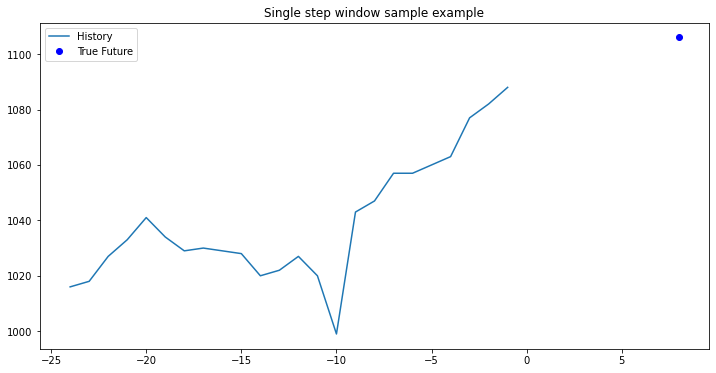

In [9]:
timestep = 30 # in minutes, can be 10, 30 or 60
perHour = round(60 / timestep) # number of observation per hour
history = (12 * perHour) # N hours history
future = (4 * perHour) # Predict N hours ahead

print ('Timestep {}m - History {}h - Looking {}m ahead'.format(timestep, round(history / perHour), future*timestep))

x_train, y_train = data_windows(ndata, history, future, single_step=True)
x_validate, y_validate = data_windows(nvdata, history, future, single_step=True)

print ('Sample window {}'.format(x_train[0]))
print ('Target level value {}'.format(y_train[0]))

show_single_plot(x_validate[0], y_validate[0], future, None, 'Single step window sample example', mean, std)

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. In this experiment, we will use a specialized RNN layer called Long Short Term Memory (LSTM):

Epoch 1/10
100/100 [==============================] - 3s 33ms/step - loss: 0.2409 - val_loss: 0.1199
Epoch 2/10
100/100 [==============================] - 3s 27ms/step - loss: 0.1024 - val_loss: 0.0914
Epoch 3/10
100/100 [==============================] - 3s 27ms/step - loss: 0.0767 - val_loss: 0.0940
Epoch 4/10
100/100 [==============================] - 3s 27ms/step - loss: 0.0607 - val_loss: 0.1108
Epoch 5/10
100/100 [==============================] - 3s 27ms/step - loss: 0.0464 - val_loss: 0.0968
Epoch 6/10
100/100 [==============================] - 3s 27ms/step - loss: 0.0398 - val_loss: 0.1055
Epoch 7/10
100/100 [==============================] - 3s 27ms/step - loss: 0.0353 - val_loss: 0.1174
Epoch 8/10
100/100 [==============================] - 3s 27ms/step - loss: 0.0376 - val_loss: 0.1063
Epoch 9/10
100/100 [==============================] - 3s 27ms/step - loss: 0.0343 - val_loss: 0.1230
Epoch 10/10
100/100 [==============================] - 3s 26ms/step - loss: 0.0333 - val_lo

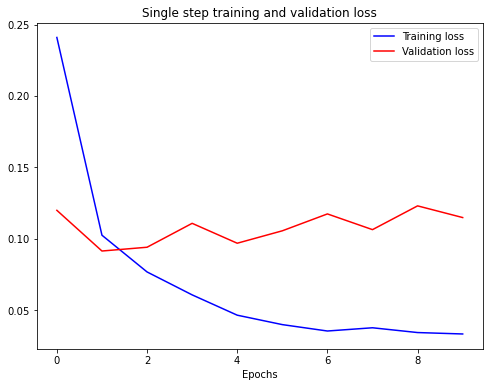

In [10]:
batch_size = 256
buffer_size = 10000

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

validate = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))
validate = validate.batch(batch_size).repeat()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:]))
model.add(tf.keras.layers.LSTM(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mae')

model_history = model.fit(train, epochs=epochs, steps_per_epoch=steps_per_epoch,
                          validation_data=validate, validation_steps=validation_steps)

plot_train_history(model_history, 'Single step training and validation loss')

In Keras the loss is calculated as a moving average over all processed batches, meaning that in the early training stage when loss drops quickly the first batch of an epoch will have a much higher loss than the last. When the epoch is finished, the shown training loss will NOT represent the training loss at the end of the epoch but the average training loss from start to end of the epoch. Therefore, it's often times higher than the validation loss, which is calculated at the end of the epoch entirely.

Fundamental rules:
- validation loss >> training loss => overfitting.
- validation loss  > training loss => some overfitting.
- validation loss  < training loss => some underfitting.
- validation loss << training loss => it underfitting.

Model is fitting very nicely the training data but not at all the validation data when overfitting occurs, in other words it's not generalizing correctly to unseen data. If both losses end up to be roughly the same, and if the values are converging, then chances are very high that we are doing it right.

Now see how it performs on some validation data:

[[0.28934445]
 [0.29164906]
 [0.3020198 ]
 [0.30893362]
 [0.31815206]
 [0.31008593]
 [0.30432441]
 [0.30547671]
 [0.30432441]
 [0.3031721 ]
 [0.29395367]
 [0.29625827]
 [0.3020198 ]
 [0.29395367]
 [0.26975527]
 [0.32045667]
 [0.32506589]
 [0.33658893]
 [0.33658893]
 [0.34004584]
 [0.34350276]
 [0.35963502]
 [0.36539654]
 [0.37231037]] 0.39305184884398164
tf.Tensor(
[[[ 0.28934445]
  [ 0.29164906]
  [ 0.3020198 ]
  ...
  [ 0.35963502]
  [ 0.36539654]
  [ 0.37231037]]

 [[ 0.29164906]
  [ 0.3020198 ]
  [ 0.30893362]
  ...
  [ 0.36539654]
  [ 0.37231037]
  [ 0.37346267]]

 [[ 0.3020198 ]
  [ 0.30893362]
  [ 0.31815206]
  ...
  [ 0.37231037]
  [ 0.37346267]
  [ 0.38498572]]

 ...

 [[-0.24532482]
  [-0.24878173]
  [-0.24878173]
  ...
  [-0.25108634]
  [-0.25223864]
  [-0.25569556]]

 [[-0.24878173]
  [-0.24878173]
  [-0.24762943]
  ...
  [-0.25223864]
  [-0.25569556]
  [-0.26030478]]

 [[-0.24878173]
  [-0.24762943]
  [-0.23495408]
  ...
  [-0.25569556]
  [-0.26030478]
  [-0.26145708]]], s

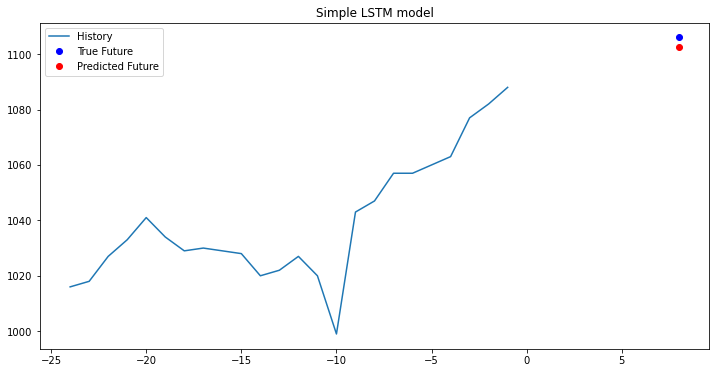

[[0.28934445]
 [0.29164906]
 [0.3020198 ]
 [0.30893362]
 [0.31815206]
 [0.31008593]
 [0.30432441]
 [0.30547671]
 [0.30432441]
 [0.3031721 ]
 [0.29395367]
 [0.29625827]
 [0.3020198 ]
 [0.29395367]
 [0.26975527]
 [0.32045667]
 [0.32506589]
 [0.33658893]
 [0.33658893]
 [0.34004584]
 [0.34350276]
 [0.35963502]
 [0.36539654]
 [0.37231037]] 0.39305184884398164
tf.Tensor(
[[[-0.24762943]
  [-0.23495408]
  [-0.2407156 ]
  ...
  [-0.26030478]
  [-0.26145708]
  [-0.24993404]]

 [[-0.23495408]
  [-0.2407156 ]
  [-0.24417251]
  ...
  [-0.26145708]
  [-0.24993404]
  [-0.25339095]]

 [[-0.2407156 ]
  [-0.24417251]
  [-0.24532482]
  ...
  [-0.24993404]
  [-0.25339095]
  [-0.25108634]]

 ...

 [[-0.15083585]
  [-0.14046511]
  [-0.1116575 ]
  ...
  [-0.11741902]
  [-0.11857133]
  [-0.11396211]]

 [[-0.14046511]
  [-0.1116575 ]
  [-0.07247915]
  ...
  [-0.11857133]
  [-0.11396211]
  [-0.10935289]]

 [[-0.1116575 ]
  [-0.07247915]
  [-0.07593606]
  ...
  [-0.11396211]
  [-0.10935289]
  [-0.11741902]]], s

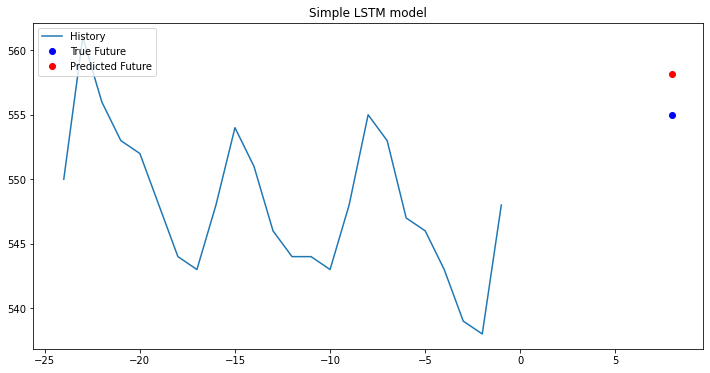

[[0.28934445]
 [0.29164906]
 [0.3020198 ]
 [0.30893362]
 [0.31815206]
 [0.31008593]
 [0.30432441]
 [0.30547671]
 [0.30432441]
 [0.3031721 ]
 [0.29395367]
 [0.29625827]
 [0.3020198 ]
 [0.29395367]
 [0.26975527]
 [0.32045667]
 [0.32506589]
 [0.33658893]
 [0.33658893]
 [0.34004584]
 [0.34350276]
 [0.35963502]
 [0.36539654]
 [0.37231037]] 0.39305184884398164
tf.Tensor(
[[[-0.07247915]
  [-0.07593606]
  [-0.13470359]
  ...
  [-0.10935289]
  [-0.11741902]
  [-0.1116575 ]]

 [[-0.07593606]
  [-0.13470359]
  [-0.13239898]
  ...
  [-0.11741902]
  [-0.1116575 ]
  [-0.10128676]]

 [[-0.13470359]
  [-0.13239898]
  [-0.12894207]
  ...
  [-0.1116575 ]
  [-0.10128676]
  [-0.0851545 ]]

 ...

 [[ 0.02777134]
  [ 0.03698977]
  [ 0.03929438]
  ...
  [ 0.06464508]
  [ 0.0704066 ]
  [ 0.06234047]]

 [[ 0.03698977]
  [ 0.03929438]
  [ 0.03468516]
  ...
  [ 0.0704066 ]
  [ 0.06234047]
  [ 0.07271121]]

 [[ 0.03929438]
  [ 0.03468516]
  [ 0.02777134]
  ...
  [ 0.06234047]
  [ 0.07271121]
  [ 0.06694969]]], s

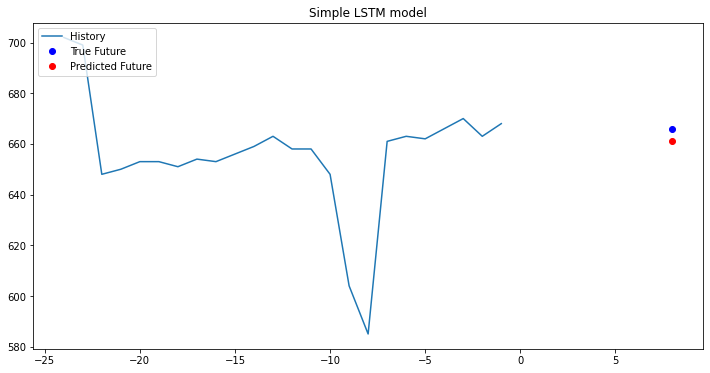

In [13]:
for x, y in validate.take(3):
  print(x_validate[0], y_validate[0])
  print(x, y)
  show_single_plot(x[0].numpy(), y[0].numpy(),
                   future, model.predict(x)[0], 'Simple LSTM model', mean, std)

Then see how it performs globally on a flood period:

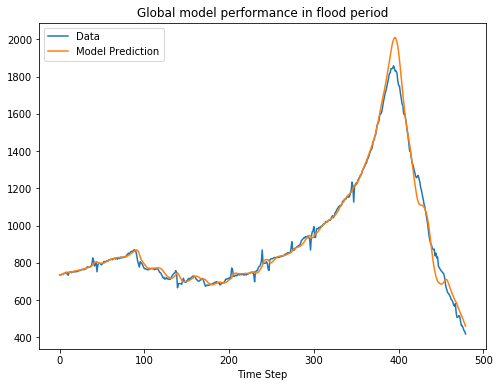

Mean Absolute Error 22.23
Max Absolute Error 141.18
Mean Absolute Percentage Error 2.38%
Max Absolute Percentage Error 15.67%
Mean Squared Error 1528.92
Root Mean Squared Error 39.10


In [140]:
# Make prediction with single-step model over input data in a given range
def predict_single(data, model, start, end):
    ground_truth = []
    prediction = []
    for i in range(start, end):
        ground_truth.append(data.values[i])
        x = []
        x.append(normalize(data.values[i-history:i], mean, std))
        x = np.array(x)
        x = np.reshape(x, (x.shape[0], x.shape[1], 1))
        prediction.append(denormalize(model.predict(x)[0][0], mean, std))
    return ground_truth, prediction
    
flood_start = 15 * 24 * perHour # 15 days after start period
flood_end = 25 * 24 * perHour # 25 days after start period
ground_truth, prediction = predict_single(validation_data, model, flood_start, flood_end)
show_prediction(ground_truth, prediction, 'Global model performance in flood period')

We will then work with the multi-step setup, ie given a past history, the model needs to learn to predict a range of future values. Data setup and model training is pretty similar except since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers.

Sample window [[-0.17272964]
 [-0.18540499]
 [-0.21075568]
 [-0.23149716]
 [-0.22919256]
 [-0.20499416]
 [-0.17157733]
 [-0.17157733]
 [-0.19692803]
 [-0.20729877]
 [-0.22804025]
 [-0.23495408]
 [-0.2395633 ]
 [-0.25339095]
 [-0.23495408]
 [-0.21075568]
 [-0.18655729]
 [-0.17618655]
 [-0.18079577]
 [-0.18194807]
 [-0.18540499]
 [-0.19116651]
 [-0.18540499]
 [-0.17964346]]
Target level values [-0.17964346 -0.17042503 -0.16927272 -0.1635112  -0.17042503 -0.17618655
 -0.18310038 -0.20729877]


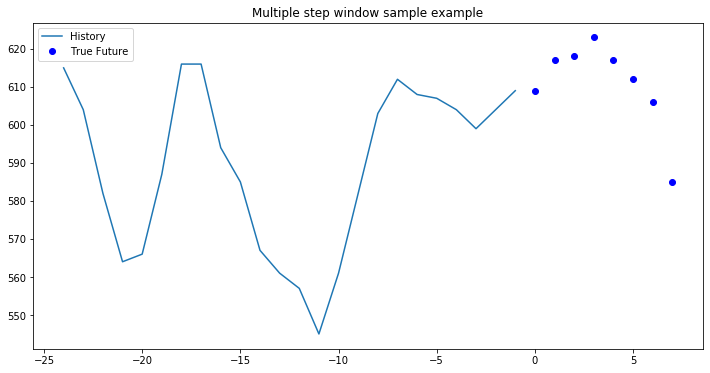

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 10s 104ms/step - loss: 0.2914 - val_loss: 0.1220
Epoch 2/10
100/100 [==============================] - 5s 46ms/step - loss: 0.1219 - val_loss: 0.0896
Epoch 3/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0874 - val_loss: 0.0783
Epoch 4/10
100/100 [==============================] - 5s 47ms/step - loss: 0.0733 - val_loss: 0.0642
Epoch 5/10
100/100 [==============================] - 5s 46ms/step - loss: 0.0639 - val_loss: 0.0480
Epoch 6/10
100/100 [==============================] - 5s 46ms/step - loss: 0.0583 - val_loss: 0.0618
Epoch 7/10
100/100 [==============================] - 5s 47ms/step - loss: 0.0535 - val_loss: 0.0566
Epoch 8/10
100/100 [==============================] - 4s 45ms/step - loss: 0.0505 - val_loss: 0.0589
Epoch 9/10
100/100 [==============================] - 4s 45ms/step - loss: 0.0484 - val_loss: 0.0564
Epoch 10/10
100/100 [=========================

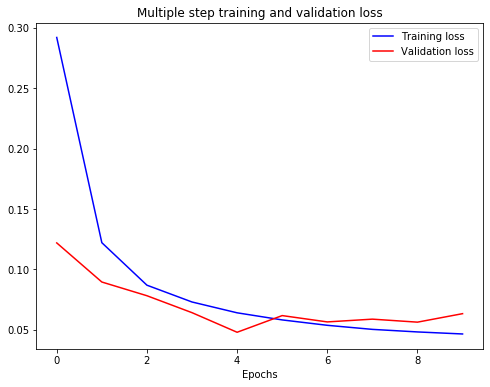

In [119]:
x_train, y_train = data_windows(ndata, history, future, single_step=False)
x_validate, y_validate = data_windows(nvdata, history, future, single_step=False)

print ('Sample window {}'.format(x_train[0]))
print ('Target level values {}'.format(y_train[0]))
    
show_multiple_plot(x_train[0], y_train[0], np.empty([0]), 'Multiple step window sample example', mean, std)

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

validate = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))
validate = validate.batch(batch_size).repeat()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:]))
model.add(tf.keras.layers.LSTM(16, activation='relu'))
model.add(tf.keras.layers.Dense(future))

model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

model_history = model.fit(train, epochs=epochs, steps_per_epoch=steps_per_epoch,
                          validation_data=validate, validation_steps=validation_steps)

plot_train_history(model_history, 'Multiple step training and validation loss')

Now see how it performs on some validation data:

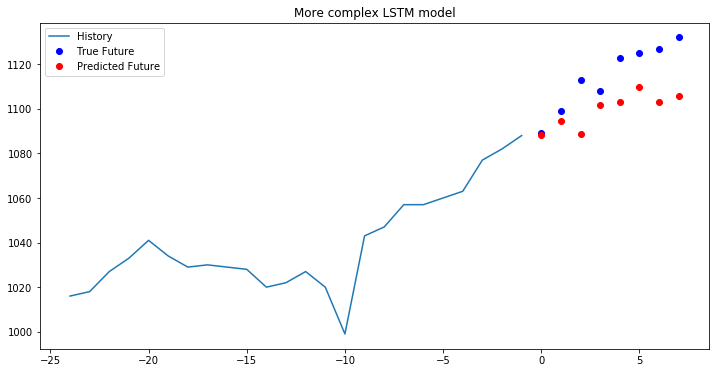

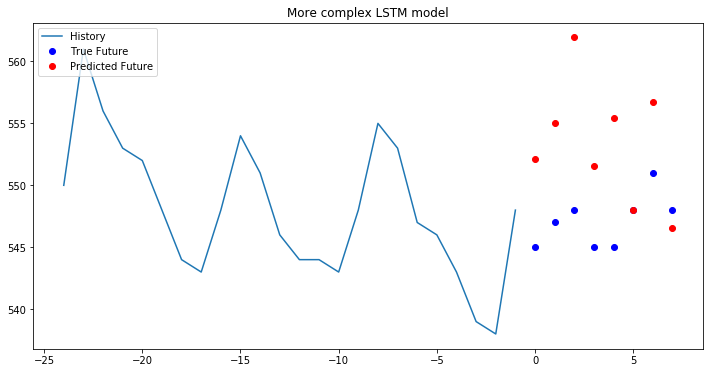

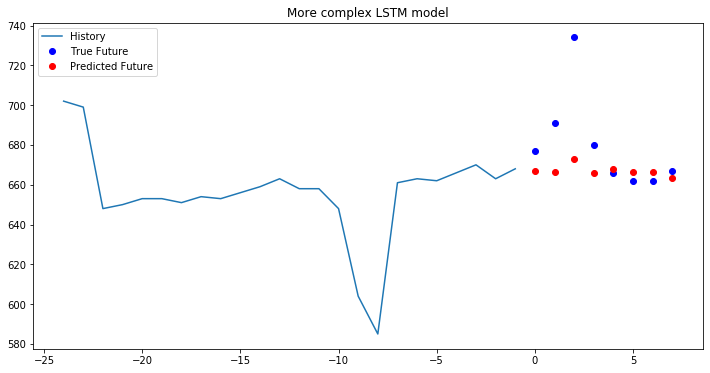

In [120]:
for x, y in validate.take(3):
  show_multiple_plot(x[0], y[0], model.predict(x)[0], 'More complex LSTM model', mean, std)

Then see how it performs globally on a flood period:

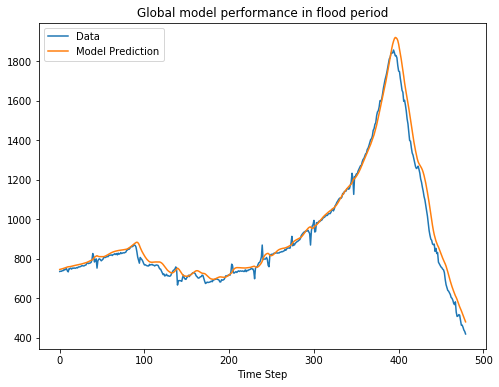

Mean Absolute Error 28.97
Max Absolute Error 82.38
Mean Absolute Percentage Error 3.28%
Max Absolute Percentage Error 16.86%
Mean Squared Error 1817.27
Root Mean Squared Error 42.63


In [131]:
# Make prediction with multiple-step model over input data in a given range
def predict_multiple(data, model, start, end):
    ground_truth = []
    prediction = []
    for i in range(flood_start, flood_end):
        ground_truth.append(data.values[i])
        x = []
        x.append(normalize(data.values[i-history:i], mean, std))
        x = np.array(x)
        x = np.reshape(x, (x.shape[0], x.shape[1], 1))
        prediction.append(denormalize(model.predict(x)[0][0], mean, std))
    return ground_truth, prediction

flood_start = 15 * 24 * perHour # 15 days after start period
flood_end = 25 * 24 * perHour # 25 days after start period
ground_truth, prediction = predict_multiple(validation_data, model, flood_start, flood_end)
show_prediction(ground_truth, prediction, 'Global model performance in flood period')

Then see how it performs globally on another station:

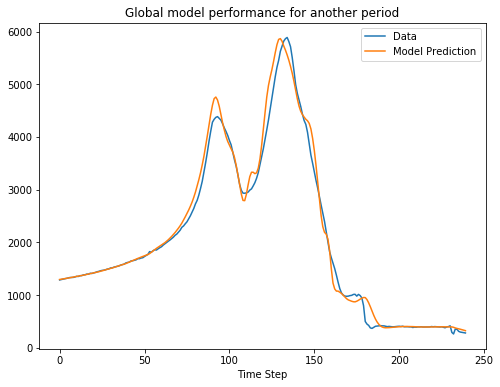

Mean Absolute Error 110.46
Max Absolute Error 385.89
Mean Absolute Percentage Error 6.94%
Max Absolute Percentage Error 106.73%
Mean Squared Error 33892.48
Root Mean Squared Error 184.10


In [133]:
# Data for testing at another but near station
test_raw = pd.read_csv("data/hubeau_site_Y1232010_30d_30m_L'Aude.csv", delimiter=';')
test_data = test_raw['resultat_obs']
test_data.index = test_raw['date_obs']
test_data.head()

flood_start = 12 * 24 * perHour # 12 days after start period
flood_end = 17 * 24 * perHour # 17 days after start period
ground_truth, prediction = predict_multiple(test_data, model, flood_start, flood_end)
show_prediction(ground_truth, prediction, 'Global model performance for another period')